### Initializations

Import 3rd party modules

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate as scint
import pathlib
import itertools as it

Import the fertilization module

In [2]:
from fertilization import *

Set the output directory (adapt as needed).

In [3]:
base_dir = pathlib.Path(".").resolve()

Make sure that figures are generated with editable texts

In [4]:
old_fonttype = plt.rcParams['svg.fonttype']

In [5]:
plt.rcParams['svg.fonttype'] = 'none'

## Include variations in both speed and % motile

Egg parameters: diameter = 120μm [note that _cross sectional_ area $A_\times = \pi r^2 = \pi (D/2)^2$], initial concentration = 50 eggs/mL, probability of fertilization given hit (fertilizability) = 0.1

In [6]:
sigma0 = np.array([
    np.pi * (0.5 * 120E-6)**2,
])
alpha_const = np.array([[0.1]])
Einit = np.array([50E6])

Create the fertilizability function from the constant value

In [7]:
def a_egg(t):
    return alpha_const

Fertilization time = 1 hour = 60 minutes = 3600 seconds

In [8]:
t_end = 60 * 60
t_array = np.arange(t_end / 4, t_end + 1, t_end / 4)

Concentration ranges logrithmically from 10 sperms per mL to 100000 sperms per mL

In [9]:
# 10**(1+6) to 10**(5+6)
Sinit_array = np.logspace(1 + 6, 5 + 6, (5 - 1) * 16 + 1, base=10)

### Case (a) normal

Speed constant at 100 μm/s, % motile constant at 80%

In [10]:
chi_gd = 0.0
SR_gd = 0.8

In [11]:
v_const_gd = np.array([100E-6])

def v_sperm_gd(t):
    return v_const_gd

In [12]:
def d_sperm_gd(t):
    return np.array([chi_gd])

Initialize the arrays for $S_0$ and $E_*$

In [13]:
S0_S_array_gd = np.zeros([Sinit_array.size, t_array.size])
Eany_S_array_gd = np.zeros([Sinit_array.size, t_array.size])

Loop through sperm concentrations, compute $S_0$ and $E_0$ and populate the arrays

NOTE that `S_init` is the concentration of motile sperm, thus the nominal concentration `_S` is multiplied by `SR_gd`

In [14]:
for _i, _S in enumerate(Sinit_array):
    model_S = FertilizationModel(
        v_sperm_gd, d_sperm_gd, np.array([_S * SR_gd]),
        a_egg, sigma0, Einit,
        t_end
    )
    model_S.solve_S0()
    model_S.solve_pmn()
    S0_S_array_gd[_i, :] = model_S.S0(t_array)[0]
    Eany_S_array_gd[_i, :] = model_S.E_any(t_array)[0]

Calculate proportion of free live sperms and fertilized eggs

In [15]:
norm_S0_S_gd = S0_S_array_gd / Sinit_array[:, np.newaxis]
norm_Eany_S_gd = Eany_S_array_gd / Einit

Plot proportion fertilized as function of sperm concentration

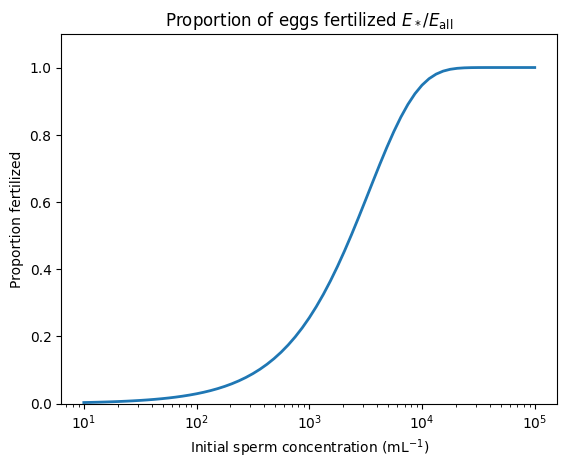

In [16]:
plt.plot(
    1E-6 * Sinit_array, norm_Eany_S_gd[:, -1], lw=2, 
    label="normal"
)

plt.title("Proportion of eggs fertilized $E_* / E_\\text{all}$")
plt.xscale("log")
#plt.yscale("log")
plt.ylim([0, 1.1])
plt.xlabel("Initial sperm concentration (mL$^{-1}$)")
plt.ylabel("Proportion fertilized")

plt.show()

Plot the proportion of free live sperm at the end of the fertilization period.

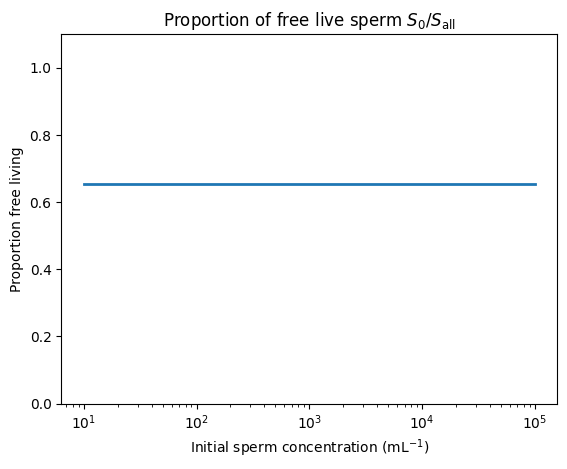

In [17]:
plt.plot(
    1E-6 * Sinit_array, norm_S0_S_gd[:, -1], lw=2, 
    label="normal"
)

plt.title("Proportion of free live sperm $S_0 / S_\\text{all}$")
plt.xscale("log")
#plt.yscale("log")
plt.ylim([0,1.1])
plt.xlabel("Initial sperm concentration (mL$^{-1}$)")
plt.ylabel("Proportion free living")

plt.show()

### Case (b) Decaying speed, normal % motile

Proportion motile constant at 0.8

In [18]:
chi_gd = 0.0
SR_gd = 0.8

In [19]:
def d_sperm_gd(t):
    return np.array([chi_gd])

Speed decreasing from 100 μm/s to 80 μm/s linearly over 1 hour

In [20]:
v_start = 100E-6
v_end = 80E-6
v_slope = (v_end - v_start) / t_end

def v_sperm_var(t):
    return v_start + v_slope * t

Initialize arrays, loop through sperm concentration, etc.

In [21]:
S0_S_array_v_bd = np.zeros([Sinit_array.size, t_array.size])
Eany_S_array_v_bd = np.zeros([Sinit_array.size, t_array.size])

In [22]:
for _i, _S in enumerate(Sinit_array):
    model_S = FertilizationModel(
        v_sperm_var, d_sperm_gd, np.array([_S * SR_gd]),
        a_egg, sigma0, Einit,
        t_end
    )
    model_S.solve_S0()
    model_S.solve_pmn()
    S0_S_array_v_bd[_i, :] = model_S.S0(t_array)[0]
    Eany_S_array_v_bd[_i, :] = model_S.E_any(t_array)[0]

In [23]:
norm_S0_S_v_bd = S0_S_array_v_bd / Sinit_array[:, np.newaxis]
norm_Eany_S_v_bd = Eany_S_array_v_bd / Einit

In [24]:
ratio_Eany_S_gd = norm_Eany_S_gd / norm_Eany_S_gd
ratio_Eany_S_v_bd = norm_Eany_S_v_bd / norm_Eany_S_gd

### Case (c): Normal speed, decaying % motile

Proportion motile reduce exponentially from 0.8 to 0.4 over 1 hour

In [25]:
SR_start = 0.8
SR_end = 0.4
chi_bd = -np.log(SR_end/SR_start) / t_end

In [26]:
def d_sperm_bd(t):
    return np.array([chi_bd])

Speed constant at 100 μm/s

In [27]:
v_const_gd = np.array([100E-6])

def v_sperm_gd(t):
    return v_const_gd

Initialize arrays, loop through sperm concentration, etc.

In [28]:
S0_S_array_x_bd = np.zeros([Sinit_array.size, t_array.size])
Eany_S_array_x_bd = np.zeros([Sinit_array.size, t_array.size])

In [29]:
for _i, _S in enumerate(Sinit_array):
    model_S = FertilizationModel(
        v_sperm_gd, d_sperm_bd, np.array([_S * SR_start]),
        a_egg, sigma0, Einit,
        t_end
    )
    model_S.solve_S0()
    model_S.solve_pmn()
    S0_S_array_x_bd[_i, :] = model_S.S0(t_array)[0]
    Eany_S_array_x_bd[_i, :] = model_S.E_any(t_array)[0]

In [30]:
norm_S0_S_x_bd = S0_S_array_x_bd / Sinit_array[:, np.newaxis]
norm_Eany_S_x_bd = Eany_S_array_x_bd / Einit

In [31]:
ratio_Eany_S_x_bd = norm_Eany_S_x_bd / norm_Eany_S_gd

### Case (d): Reduced (time constant) speed and % motile

Speed constant at 90 μm/s

In [32]:
v_const_bd = np.array([90E-6])

def v_sperm_bd(t):
    return v_const_bd

Proportion motile constant at 57.7% (equal to the average of the decaying case)

In [33]:
SR_start = 0.8
SR_end = 0.4
chi_bd = -np.log(SR_end/SR_start) / t_end

In [34]:
chi_gd = 0.0

def d_sperm_gd(t):
    return np.array([chi_gd])

In [35]:
area_under = scint.quad(lambda t: SR_start * np.exp(-chi_bd * t), 0, t_end)
SR_avg = area_under[0] / t_end

In [36]:
print(area_under)
print(SR_avg)

(2077.480858880108, 2.3064670827467415e-11)
0.5770780163555855


Initialize arrays, define sperm decay, loop through sperm concentration, etc.

In [37]:
S0_S_array_bd2 = np.zeros([Sinit_array.size, t_array.size])
Eany_S_array_bd2 = np.zeros([Sinit_array.size, t_array.size])

In [38]:
for _i, _S in enumerate(Sinit_array):
    model_S = FertilizationModel(
        v_sperm_bd, d_sperm_gd, np.array([_S * SR_avg]),
        a_egg, sigma0, Einit,
        t_end
    )
    model_S.solve_S0()
    model_S.solve_pmn()
    S0_S_array_bd2[_i, :] = model_S.S0(t_array)[0]
    Eany_S_array_bd2[_i, :] = model_S.E_any(t_array)[0]

In [39]:
norm_S0_S_bd2 = S0_S_array_bd2 / Sinit_array[:, np.newaxis]
norm_Eany_S_bd2 = Eany_S_array_bd2 / Einit

Plot proportion fertilized as function of sperm concentration, including both the normal and the reduced cases

Save the plot in both `.svg` and `.pdf` formats

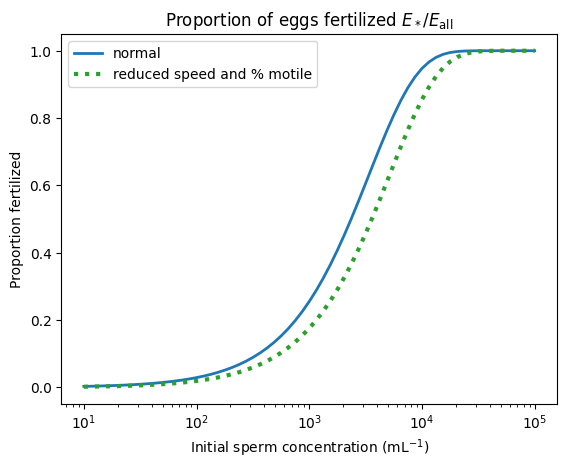

In [40]:
# trick to skip colors in the default plot color cycle
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = it.cycle(prop_cycle.by_key()['color'])

plt.plot(
    1E-6 * Sinit_array, norm_Eany_S_gd[:, -1], lw=2,
    c=next(colors), label="normal"
)

next(colors)

plt.plot(
    1E-6 * Sinit_array, norm_Eany_S_bd2[:, -1], lw=3, ls=":",
    c=next(colors), label="reduced speed and % motile"
)

plt.title("Proportion of eggs fertilized $E_* / E_\\text{all}$")
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("Initial sperm concentration (mL$^{-1}$)")
plt.ylabel("Proportion fertilized")
plt.legend()

plt.show()

Compute the proportion fertilized _relative_ to the normal case

In [41]:
ratio_Eany_S_bd2 = norm_Eany_S_bd2 / norm_Eany_S_gd

Plot the relative proportion fertilized as function of concentration, and save

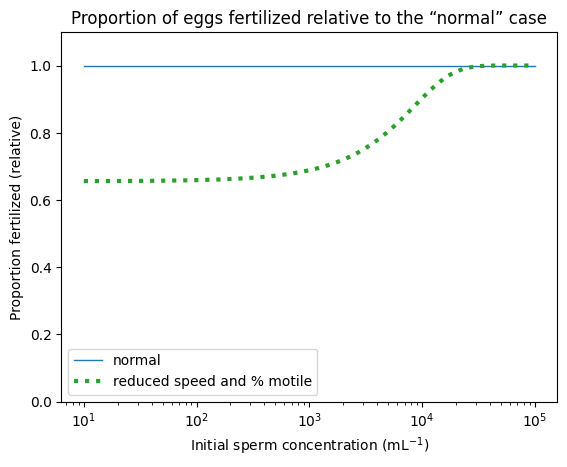

In [42]:
# trick to skip colors in the default plot color cycle
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = it.cycle(prop_cycle.by_key()['color'])

plt.plot(
    1E-6 * Sinit_array, ratio_Eany_S_gd[:, -1], lw=1, 
    c=next(colors), label="normal"
)

next(colors)

plt.plot(
    1E-6 * Sinit_array, ratio_Eany_S_bd2[:, -1], lw=3, ls=":",
    c=next(colors), label="reduced speed and % motile"
)

plt.title("Proportion of eggs fertilized relative to the “normal” case")
plt.xscale("log")
#plt.yscale("log")
plt.ylim([0, 1.1])
plt.xlabel("Initial sperm concentration (mL$^{-1}$)")
plt.ylabel("Proportion fertilized (relative)")
plt.legend()

plt.show()

### Case (e): Decaying (time-varying) speed and % motile

Speed decreasing from 100 μm/s to 80 μm/s linearly over 1 hour

In [43]:
v_start = 100E-6
v_end = 80E-6
v_slope = (v_end - v_start) / t_end

def v_sperm_var(t):
    return v_start + v_slope * t

Proportion motile reduce exponentially from 0.8 to 0.4 over 1 hour

In [44]:
SR_start = 0.8
SR_end = 0.4
chi_bd = -np.log(SR_end/SR_start) / t_end

Initialize arrays, define sperm decay, loop through sperm concentration, etc.

In [45]:
S0_S_array_bd = np.zeros([Sinit_array.size, t_array.size])
Eany_S_array_bd = np.zeros([Sinit_array.size, t_array.size])

In [46]:
for _i, _S in enumerate(Sinit_array):
    model_S = FertilizationModel(
        v_sperm_var, d_sperm_bd, np.array([_S * SR_start]),
        a_egg, sigma0, Einit,
        t_end
    )
    model_S.solve_S0()
    model_S.solve_pmn()
    S0_S_array_bd[_i, :] = model_S.S0(t_array)[0]
    Eany_S_array_bd[_i, :] = model_S.E_any(t_array)[0]

In [47]:
norm_S0_S_bd = S0_S_array_bd / Sinit_array[:, np.newaxis]
norm_Eany_S_bd = Eany_S_array_bd / Einit

Plot proportion fertilized as function of sperm concentration, both for the normal and the double decaying case

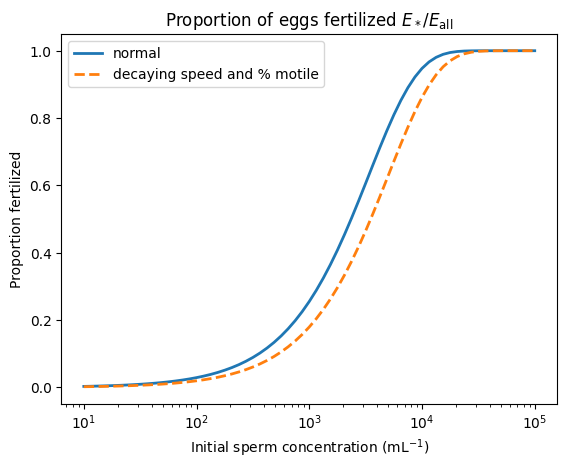

In [48]:
plt.plot(
    1E-6 * Sinit_array, norm_Eany_S_gd[:, -1], lw=2,
    label="normal"
)

plt.plot(
    1E-6 * Sinit_array, norm_Eany_S_bd[:, -1], lw=2, ls="--",
    label="decaying speed and % motile"
)

plt.title("Proportion of eggs fertilized $E_* / E_\\text{all}$")
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("Initial sperm concentration (mL$^{-1}$)")
plt.ylabel("Proportion fertilized")
plt.legend()

plt.show()

In [49]:
ratio_Eany_S_bd = norm_Eany_S_bd / norm_Eany_S_gd

Plot the relative proportion fertilized as function of concentration

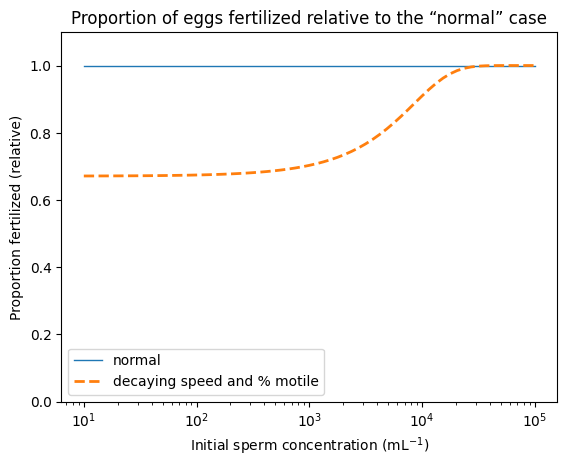

In [50]:
plt.plot(
    1E-6 * Sinit_array, ratio_Eany_S_gd[:, -1], lw=1, 
    label="normal"
)
plt.plot(
    1E-6 * Sinit_array, ratio_Eany_S_bd[:, -1], lw=2, ls="--",
    label="decaying speed and % motile"
)

plt.title("Proportion of eggs fertilized relative to the “normal” case")
plt.xscale("log")
#plt.yscale("log")
plt.ylim([0, 1.1])
plt.xlabel("Initial sperm concentration (mL$^{-1}$)")
plt.ylabel("Proportion fertilized (relative)")
plt.legend()

plt.show()

### Combining results

Plot cases (a) -- (e)

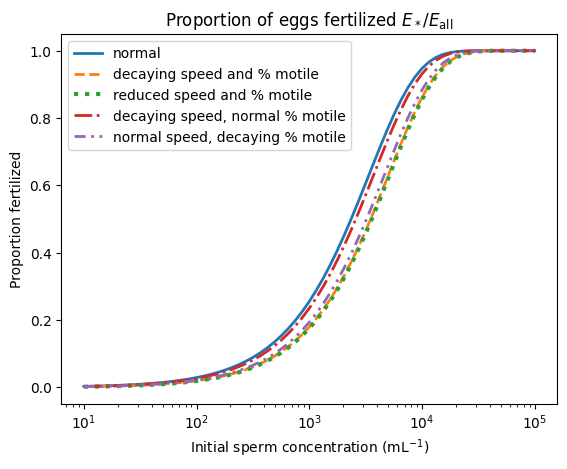

In [51]:
# custom "dash-dot-dot" linestyle
dashdotdot = (0, (4, 2, 1, 2, 1, 2))

plt.plot(
    1E-6 * Sinit_array, norm_Eany_S_gd[:, -1], lw=2, 
    label="normal"
)
plt.plot(
    1E-6 * Sinit_array, norm_Eany_S_bd[:, -1], lw=2, ls="--",
    label="decaying speed and % motile"
)
plt.plot(
    1E-6 * Sinit_array, norm_Eany_S_bd2[:, -1], lw=3, ls=":", 
    label="reduced speed and % motile"
)
plt.plot(
    1E-6 * Sinit_array, norm_Eany_S_v_bd[:, -1], lw=2, ls="-.",
    label="decaying speed, normal % motile"
)
plt.plot(
    1E-6 * Sinit_array, norm_Eany_S_x_bd[:, -1], lw=2, ls=dashdotdot, 
    label="normal speed, decaying % motile"
)

plt.title("Proportion of eggs fertilized $E_* / E_\\text{all}$")
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("Initial sperm concentration (mL$^{-1}$)")
plt.ylabel("Proportion fertilized")
plt.legend()

plt.savefig(base_dir / 'prop_fert_all.pdf')
plt.savefig(base_dir / 'prop_fert_all.svg')

plt.show()

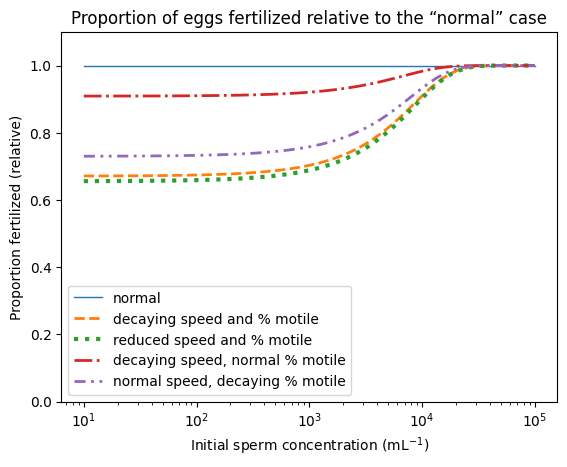

In [52]:
plt.plot(
    1E-6 * Sinit_array, ratio_Eany_S_gd[:, -1], lw=1, 
    label="normal"
)
plt.plot(
    1E-6 * Sinit_array, ratio_Eany_S_bd[:, -1], lw=2, ls="--",
    label="decaying speed and % motile"
)
plt.plot(
    1E-6 * Sinit_array, ratio_Eany_S_bd2[:, -1], lw=3, ls=":",
    label="reduced speed and % motile"
)
plt.plot(
    1E-6 * Sinit_array, ratio_Eany_S_v_bd[:, -1], lw=2, ls="-.",
    label="decaying speed, normal % motile"
)
plt.plot(
    1E-6 * Sinit_array, ratio_Eany_S_x_bd[:, -1], lw=2, ls=dashdotdot,
    label="normal speed, decaying % motile"
)

plt.title("Proportion of eggs fertilized relative to the “normal” case")
plt.xscale("log")
#plt.yscale("log")
plt.ylim([0, 1.1])
plt.xlabel("Initial sperm concentration (mL$^{-1}$)")
plt.ylabel("Proportion fertilized (relative)")
plt.legend()

plt.savefig(base_dir / 'ratio_fert_all.pdf')
plt.savefig(base_dir / 'ratio_fert_all.svg')

plt.show()

Plot the difference between the decaying case and the reduced (time-constant) cases, relative to the reduced case (not saved)

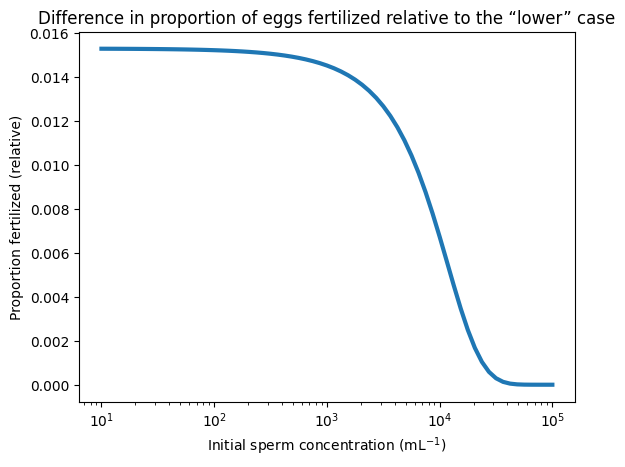

In [53]:
plt.plot(
    1E-6 * Sinit_array, 
    (ratio_Eany_S_bd[:, -1] - ratio_Eany_S_bd2[:, -1]) / ratio_Eany_S_gd[:, -1], 
    label="decaying speed and % motile", lw=3
)

plt.title("Difference in proportion of eggs fertilized relative to the “lower” case")
plt.xscale("log")
#plt.yscale("log")
#plt.ylim([0, 1.1])
plt.xlabel("Initial sperm concentration (mL$^{-1}$)")
plt.ylabel("Proportion fertilized (relative)")

plt.show()

## Saving results

Construct the correct sperm concentration and time point labels for serialized numpy arrays

In [54]:
S_grid, t_grid = np.meshgrid(
    Sinit_array, t_array, indexing='ij'
)

Construct dataframes for the proportion fertilized data for the cases (a) -- (e)

In [55]:
df_gd = pd.DataFrame({
    "time (s)": t_grid.ravel(),
    "Sinit (m^-3)": S_grid.ravel(),
    "S0 prop": norm_S0_S_gd.ravel(),
    "E_* prop": norm_Eany_S_gd.ravel(),
    "E_* ratio": ratio_Eany_S_gd.ravel(),
})
df_v_bd = pd.DataFrame({
    "time (s)": t_grid.ravel(),
    "Sinit (m^-3)": S_grid.ravel(),
    "S0 prop": norm_S0_S_v_bd.ravel(),
    "E_* prop": norm_Eany_S_v_bd.ravel(),
    "E_* ratio": ratio_Eany_S_v_bd.ravel(),
})
df_x_bd = pd.DataFrame({
    "time (s)": t_grid.ravel(),
    "Sinit (m^-3)": S_grid.ravel(),
    "S0 prop": norm_S0_S_x_bd.ravel(),
    "E_* prop": norm_Eany_S_x_bd.ravel(),
    "E_* ratio": ratio_Eany_S_x_bd.ravel(),
})
df_bd = pd.DataFrame({
    "time (s)": t_grid.ravel(),
    "Sinit (m^-3)": S_grid.ravel(),
    "S0 prop": norm_S0_S_bd.ravel(),
    "E_* prop": norm_Eany_S_bd.ravel(),
    "E_* ratio": ratio_Eany_S_bd.ravel(),
})
df_bd2 = pd.DataFrame({
    "time (s)": t_grid.ravel(),
    "Sinit (m^-3)": S_grid.ravel(),
    "S0 prop": norm_S0_S_bd2.ravel(),
    "E_* prop": norm_Eany_S_bd2.ravel(),
    "E_* ratio": ratio_Eany_S_bd2.ravel(),
})

Write to Excel (with each dataframe a separate sheet)

In [56]:
with pd.ExcelWriter('both_variations.xlsx', mode='w') as writer:  
    df_gd.to_excel(writer, sheet_name='normal', index=False)
    df_v_bd.to_excel(writer, sheet_name='bad_speed', index=False)
    df_x_bd.to_excel(writer, sheet_name='bad_motile_prop', index=False)
    df_bd2.to_excel(writer, sheet_name='both_reduced', index=False)
    df_bd.to_excel(writer, sheet_name='both_bad', index=False)

Record the relevant parameters used and save to file

In [57]:
param_str = f'''
sigma0 = {sigma0.item()}
alpha = {alpha_const.item()}
Einit = {Einit.item()}

t_end = {t_end}

v_sperm_gd = {v_const_gd.item()}

v_sperm_bd = {v_const_bd.item()}

v_start = {v_start}
v_end = {v_end}
v_slope = {v_slope}

SR_gd = {SR_gd}
d_sperm_gd = {chi_gd}

SR_start = {SR_start}
SR_end = {SR_end}
d_sperm_bd= {chi_bd}

SR_avg = {SR_avg}
'''

In [58]:
with open(base_dir / "both_var_params.txt", "w") as outfile:
    outfile.write(param_str)